# Baysian Regression model- Price Elasticity
- Lecture
- Online source
- Lin paper
- Data Camp
- Basic Baysian inference: Two groups continous outcomes
    - reduced  dataset, treated_b split, only 2013

In [1]:
# Import necessary package 
import pandas as pd
import numpy as np
import seaborn as sn
import tensorflow as tf
import pymc as pm
from scipy import optimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import arviz as az
import tensorflow as tf

import altair as alt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
import sys

import datetime as dt
#import pandas_datareader.data as web
import requests
from bs4 import BeautifulSoup
import textwrap

# For model fit
import matplotlib.colors as colors
import matplotlib as mpl
import matplotlib.cm as mplcm

# for reproducable results
import random

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tmp/ipykernel_39364/2207691754.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
SEED = 5
np.random.seed(SEED)

In [3]:
# 0. Reading-in Set that has missings
water_baysian = pd.read_csv('water_rate_change.csv')
water_baysian.dtypes

year                        int64
id_c                        int64
state                       int64
first_rate_change_year      int64
ever_treated                int64
treat_post                  int64
event_time_rate_change      int64
grund_perfirm             float64
high_gw_rate                int64
rate_gw                   float64
log_gdp                   float64
log_mean_precip           float64
log_sw_area               float64
log_pop_density           float64
log_fremdbezug            float64
post                        int64
log_grund_perfirm         float64
log_rate_gw               float64
dtype: object

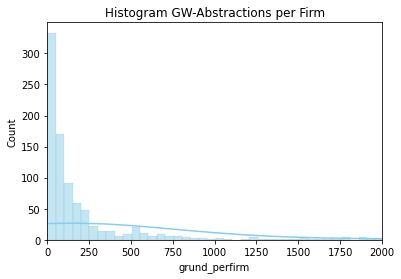

In [12]:
sn.histplot(data= water_baysian, x= 'grund_perfirm', kde= True,color =  'skyblue');
plt.xlim(0,2000)
plt.title('Histogram GW-Abstractions per Firm')
plt.show()

# 1. Transforming

In [18]:

# convert to float 32 and round to 3 for staorage saving
water_baysian['log_gdp'] =water_baysian['log_gdp'].round(3).astype('float32')
water_baysian['log_mean_precip'] =water_baysian['log_mean_precip'].round(3).astype('float32')
water_baysian['log_pop_density'] =water_baysian['log_pop_density'].round(3).astype('float32')
water_baysian['log_fremdbezug_perfirm'] = water_baysian['log_fremdbezug'].round(3).astype('float32')
water_baysian['log_sw_area'] = water_baysian['log_sw_area'].round(3).astype('float32')
water_baysian['log_rate_gw'] = water_baysian['log_rate_gw'].round(3).astype('float32')


In [ ]:
fig, axs = plt.subplots(3,3, figsize = (12,12))

sn.histplot(data = water_baysian, x = 'log_grund_perfirm', kde = True, color = 'skyblue', ax = axs[0,0]).set(title='log-GW per firm')
sn.histplot(data = water_baysian, x = 'log_gdp', kde = True, color = 'yellow', ax = axs[0,1]).set(title='log GDP')
sn.histplot(data = water_baysian, x = 'treated_b', kde = True, color = 'green', ax = axs[0,2]).set(title='WAF y/N')
sn.histplot(data = water_baysian, x = 'log_mean_precip', kde = True, color = 'red', ax = axs[1,0]).set(title='log-Precipitation')
sn.histplot(data = water_baysian, x = 'log_pop_density', kde = True, color = 'magenta', ax = axs[1,1]).set(title='log Population density')
sn.histplot(data = water_baysian, x = 'log_fremdbezug_perfirm', kde = True, color = 'orange', ax = axs[1,2]).set(title='log-Fremdbezug per firm')
sn.histplot(data = water_baysian, x = 'rate_gw', kde = True, color = 'orange', ax = axs[2,0]).set(title='Rate')

plt.show()



# 2. Standardizing Data
We are dealing with the nas in the Dataset by masking them at this point and and standardize them according to the process implemented in the Lecture. The masked arrays are just used when we turn to the Baysian Regression.

In [19]:
def standardize_ma(x):
    x_ma = np.ma.masked_invalid(x)
    return (x_ma-x_ma.mean())/x_ma.std()

In [20]:
# Standardize the y variable
log_grund_perfirm = standardize_ma((water_baysian['log_grund_perfirm']))
# Standardize MA the explanatory variables

log_gdp = standardize_ma(water_baysian['log_gdp'])
log_mean_precip = standardize_ma(water_baysian['log_mean_precip'])
log_pop_density = standardize_ma(water_baysian['log_pop_density'])
log_fremdbezug_perfirm = standardize_ma(water_baysian['log_fremdbezug_perfirm'])
log_rate_gw = standardize_ma(water_baysian['log_rate_gw'])
log_sw_area = standardize_ma(water_baysian['log_sw_area'])

In [21]:
# convert to arrays
log_grund_perfirm = np.array(log_grund_perfirm)
log_gdp= np.array(log_gdp)
log_mean_precip= np.array(log_mean_precip)
log_pop_density = np.array(log_pop_density)
log_fremdbezug_perfirm = np.array(log_fremdbezug_perfirm)

log_rate_gw = np.array(water_baysian['log_rate_gw'])
log_sw_area = np.array(log_sw_area)

In [22]:

# Post and post treated indicator
water_baysian['post'] = (water_baysian['year']>=water_baysian['first_rate_change_year']).astype('Int32')
water_baysian['treat_post']= water_baysian['post']* water_baysian['ever_treated']  
post = np.array(water_baysian['post'])

In [23]:
water_baysian.loc[(water_baysian['state']==12)&(water_baysian['year']==2013)]

,year,id_c,state,first_rate_change_year,ever_treated,treat_post,event_time_rate_change,grund_perfirm,high_gw_rate,rate_gw,log_gdp,log_mean_precip,log_sw_area,log_pop_density,log_fremdbezug,post,log_grund_perfirm,log_rate_gw,log_fremdbezug_perfirm
539,2013,12060,12,2019,1,0,-6,35.470588,0,0.1,15.007,6.367,8.919,4.774,2.079442,0,3.596506,-2.302,2.079
540,2013,12051,12,2019,1,0,-6,45.714286,0,0.1,14.496,6.473,8.326,5.737,5.949107,0,3.844050,-2.302,5.949
541,2013,12052,12,2019,1,0,-6,17201.705882,0,0.1,14.928,6.473,5.587,6.404,7.892779,0,9.752822,-2.302,7.893
542,2013,12061,12,2019,1,0,-6,105.037037,0,0.1,15.430,6.503,9.106,4.272,3.360890,0,4.663788,-2.302,3.361
543,2013,12062,12,2019,1,0,-6,87.550000,0,0.1,14.637,6.534,8.056,4.041,3.017983,0,4.483567,-2.302,3.018
544,2013,12053,12,2019,1,0,-6,5.000000,0,0.1,14.458,6.473,6.308,5.975,5.498533,0,1.791759,-2.302,5.499
545,2013,12063,12,2019,1,0,-6,41.882353,0,0.1,14.838,6.473,8.632,4.501,5.259638,0,3.758460,-2.302,5.260
546,2013,12064,12,2019,1,0,-6,567.130435,0,0.1,15.056,6.328,8.765,4.476,1.982500,0,6.342351,-2.302,1.982
547,2013,12065,12,2019,1,0,-6,40.571429,0,0.1,15.358,6.400,8.883,4.730,3.205453,0,3.727413,-2.302,3.205
548,2013,12066,12,2019,1,0,-6,326.076923,0,0.1,14.767,6.726,8.324,4.544,3.587783,0,5.790195,-2.302,3.588


# 3. Baysian Regression 
 - SOO
 - RPF & SA
 - uninformed prior: 

 - Check Assumptions and Model FIt

In [24]:
# model für a und b
def outcome_cov_change(t, control_intercept, treat_intercept_delta, trend, d, group, treated,b_log_gdp , Log_gdp , b_log_mean_precip ,Log_mean_precip , b_log_pop_density ,Log_pop_density , b_log_fremdbezug_perfirm , Log_mean_fremdbezug_perfirm ,
         b_log_sw_area,Log_sw_area, Log_rate_gw, b_log_rate_gw):
    return control_intercept + (treat_intercept_delta * group) + (t * trend) + (d * treated * group) + (b_log_rate_gw*Log_rate_gw) +(b_log_gdp * Log_gdp) + (b_log_mean_precip * Log_mean_precip) + (b_log_pop_density * Log_pop_density) + (b_log_fremdbezug_perfirm * Log_mean_fremdbezug_perfirm) + (b_log_sw_area * Log_sw_area)


with pm.Model() as bm_vinc_rate_full:
    # data
    t = pm.MutableData("t", water_baysian["post"].values, dims="obs_idx")
    treated = pm.MutableData("treated", water_baysian["treat_post"].values, dims="obs_idx")
    group = pm.MutableData("group", water_baysian["ever_treated"].values, dims="obs_idx")
    σ_prior = 0.1
    # Covariates
    b_log_gdp = pm.Normal('b_log_gdp', mu=0.0, sigma=σ_prior)
    b_log_mean_precip = pm.Normal('b_log_mean_precip', mu=0.0, sigma=σ_prior)
    b_log_pop_density = pm.Normal('b_log_pop_density', mu=0.0, sigma=σ_prior)
    b_log_fremdbezug_perfirm = pm.Normal('b_log_fremdbezug_perfirm', mu=0.0, sigma=σ_prior)
    b_log_sw_area = pm.Normal('b_log_sw_area', mu=0.0, sigma=σ_prior)
    b_log_rate_gw = pm.Normal('b_log_rate_gw', mu = 0.0,sigma =σ_prior )
    # Observations
    Log_gdp = pm.Normal('Log_gdp', mu=0, sigma=1.0, observed=log_gdp)
    Log_pop_density = pm.Normal('Log_pop_density', mu=0, sigma=1.0, observed=log_pop_density)
    Log_mean_precip = pm.Normal('Log_mean_precip', mu=0, sigma=1.0, observed=log_mean_precip)
    Log_mean_fremdbezug_perfirm = pm.Normal('Log_mean_fremdbezug_perfirm', mu=0, sigma=1.0, observed=log_fremdbezug_perfirm)
    Log_sw_area = pm.Normal('Log_sw_area', mu=0, sigma=1.0, observed=log_sw_area)
    Log_rate_gw = pm.Normal('Log_rate_gw', mu =0,sigma =1.0, observed=log_rate_gw )
    
    # Priors
    _control_intercept = pm.Normal("control_intercept", 0, 1)
    _treat_intercept_delta = pm.Normal("treat_intercept_delta", 0, 1)
    _trend = pm.Normal("trend", 0, 1)
    _d = pm.Normal("d", 0, 0.5)
    sigma = pm.HalfNormal("sigma", 1)
    
    # expectation
    mu = pm.Deterministic(
        "mu",
        outcome_cov_change(t, _control_intercept, _treat_intercept_delta, _trend, _d, group, treated,b_log_gdp , Log_gdp , b_log_mean_precip ,Log_mean_precip , b_log_pop_density ,Log_pop_density , b_log_fremdbezug_perfirm , Log_mean_fremdbezug_perfirm ,
         b_log_sw_area,Log_sw_area, Log_rate_gw, b_log_rate_gw),
        dims="obs_idx",
    )
    # likelihood
    pm.Normal("obs", mu, sigma, observed=log_grund_perfirm, dims="obs_idx")

/opt/conda/lib/python3.9/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [b_log_gdp, b_log_mean_precip, b_log_pop_density, b_log_fremdbezug_perfirm, b_log_sw_area, b_log_rate_gw, control_intercept, treat_intercept_delta, trend, d, sigma, obs_unobserved]


Sampling 3 chains for 1_000 tune and 500 draw iterations (3_000 + 1_500 draws total) took 376 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


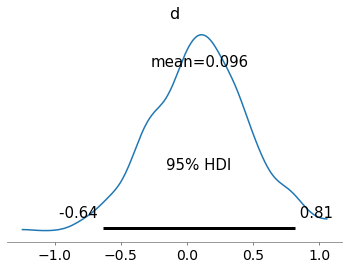

In [25]:
with bm_vinc_rate_full:
    idata_full = pm.sample(draws= 500, cores= 3, return_inferencedata = True)
    
    
trace = idata_full.posterior 
az.plot_posterior(trace, var_names =["d"], hdi_prob = 0.95);

In [26]:
variables_ofinterest = ['control_intercept', 'd','trend', 'treat_intercept_delta','b_log_rate_gw','b_log_gdp', 'b_log_mean_precip', 'b_log_pop_density','b_log_fremdbezug_perfirm', 'b_log_sw_area' ]
summary_pm = pm.summary(idata_full, var_names=variables_ofinterest)

summary_pm.columns

Index(['mean', 'sd', 'hdi_3%', 'hdi_97%', 'mcse_mean', 'mcse_sd', 'ess_bulk',
       'ess_tail', 'r_hat'],
      dtype='object')

In [27]:
selected_summary_df = summary_pm[['mean', 'sd','hdi_3%','hdi_97%', 'r_hat']]

formatted_df= selected_summary_df.applymap(lambda x : f'{x:.3f}')

formatted_df.reset_index(inplace= True)
formatted_df.rename(columns= {'index':'Variable', 'mean':'Mean', 'sd':'SD'}, inplace = True)
formatted_df.to_csv('baysian_rate_summary.csv', index=False)
formatted_df

/tmp/ipykernel_39006/3289798271.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_df= selected_summary_df.applymap(lambda x : f'{x:.3f}')


,Variable,Mean,SD,hdi_3%,hdi_97%,r_hat
0,control_intercept,-0.105,0.422,-0.903,0.668,1.000
1,d,0.096,0.369,-0.594,0.814,1.000
2,trend,-0.184,0.374,-0.947,0.464,1.000
3,treat_intercept_delta,0.376,0.368,-0.346,1.048,1.000
4,b_log_rate_gw,0.025,0.077,-0.117,0.171,1.000
5,b_log_gdp,-0.065,0.037,-0.133,0.006,1.000
6,b_log_mean_precip,-0.007,0.032,-0.067,0.049,1.000
7,b_log_pop_density,0.054,0.046,-0.031,0.142,1.000
8,b_log_fremdbezug_perfirm,0.350,0.031,0.294,0.410,1.000
9,b_log_sw_area,0.015,0.040,-0.057,0.094,1.000


In [28]:
latex_pm_table= formatted_df.to_latex(index = False, caption = 'Summary Baysian - DiD', label = 'table:rate_baysian_did_model',longtable = False,escape = False)

with open('rate_bayes_did_summary_table.tex','w') as f:
    f.write(latex_pm_table)